<h1 style="text-align: center;">Email click through rate - Jackson Yang</h1>

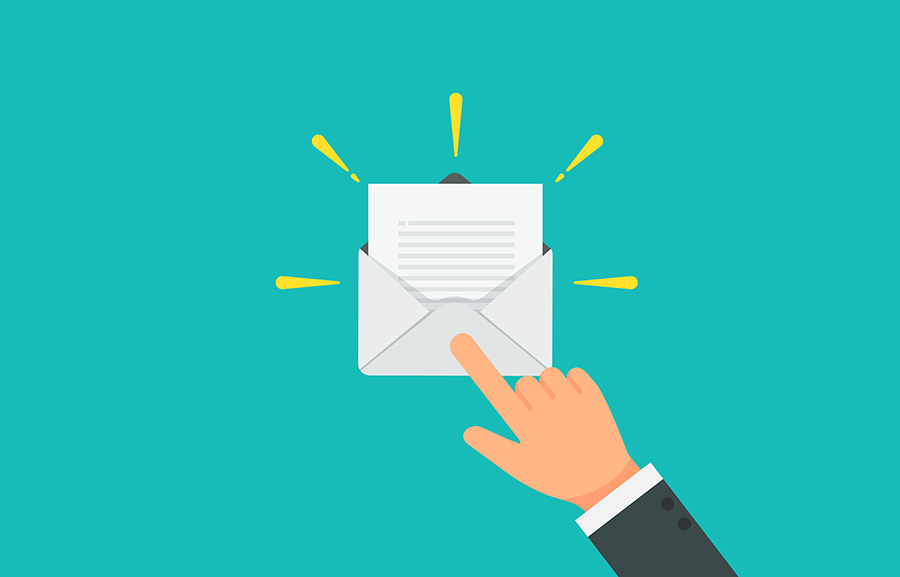

## Table of Content:
* [1. Load data and libraries](#first-bullet)
* [2. Exploratory data analysis](#second-bullet)
* [3. Model Building](#third-bullet)
* [4. Main takeaways](#fourth-bullet)

**Problem Statement**

The marketing department wants to know the important factors impacting the email click-through-rate(CR) and how to improve the CR. They want to increase the percentage of *customers who click on the link inside the email*.

**Variables description**

- **email_id** : the Id of the email that was sent. It is unique by email
- **email_text**: two different versions of the email have been sent: one has "long text" (i.e. has 4 paragraphs)and one has "short text" Oust two paragraphs)
- **email_version**: some emails were "personalized" (i.e. they had the name of the user receiving the email in the incipit, such as "Hi John,"), while some emails were "generic" (the incipit was just "Hi,")
- **hour**: the local time on which the email was sent
- **weekday**: the weekday on which the email was sent
- **user_country**: the country where the user receiving the email is based. It comes from the user ip address when they created the account
- **user_past_purchases**: how many items in the past were bought by the user receiving the email
- **clicked** - Whether the user has clicked on the link inside the email. This is our label and, most importantly, the goal of the project is to increase this

## 1. Load data and libraries <a class="anchor" id="first-bullet"></a>

In [307]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.warnings.filterwarnings('ignore')

In [308]:
df = pd.read_csv('course1_data_emails.csv', index_col= "email_id")

## 2. Exploratory data analysis <a class="anchor" id="second-bullet"></a>

### 2.1 General overview of the data

In [309]:
df.head()

,email_text,email_version,hour,weekday,user_country,user_past_purchases,clicked
email_id,,,,,,,
8,short_email,generic,9,Thursday,US,3,0
33,long_email,personalized,6,Monday,US,0,0
46,short_email,generic,14,Tuesday,US,3,0
49,long_email,personalized,11,Thursday,US,10,0
65,short_email,generic,8,Wednesday,UK,3,0


In [310]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99950 entries, 8 to 999998
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   email_text           99950 non-null  object
 1   email_version        99950 non-null  object
 2   hour                 99950 non-null  int64 
 3   weekday              99950 non-null  object
 4   user_country         99950 non-null  object
 5   user_past_purchases  99950 non-null  int64 
 6   clicked              99950 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 6.1+ MB


**Inference**
- no null value
- data type are all ok

In [311]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
hour,99950.0,9.059100,4.439618,1.0,6.0,9.0,12.0,24.0
user_past_purchases,99950.0,3.878559,3.196324,0.0,1.0,3.0,6.0,22.0
clicked,99950.0,0.020700,0.142380,0.0,0.0,0.0,0.0,1.0


**Inference**
- We can see that CR is quite low with only 2.07%
- On average, the receivers of the emails consumed 3.87 items  

### 2.2 Data Visualization

#### 2.2.1 email_text

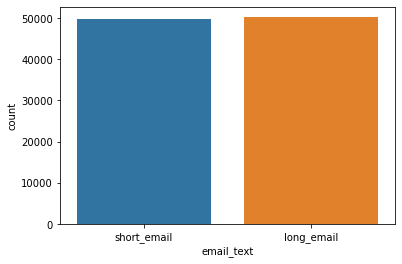

In [312]:
sns.countplot(data=df, x='email_text');

In [313]:
df['email_text'].value_counts()

long_email     50248
short_email    49702
Name: email_text, dtype: int64

**Inference**
- we can see that long email is slightly more than short email
- we can probably guess that people who received the short-email might be more likely to open the email compared to the long email (let's find out if this is true)

<AxesSubplot:xlabel='clicked', ylabel='count'>

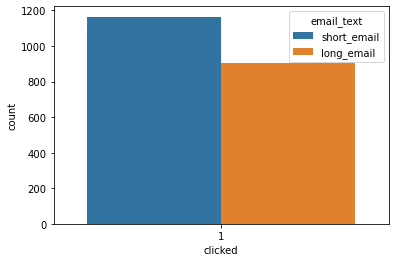

In [314]:
sns.countplot(data = df[df.clicked == 1], x='clicked',hue='email_text')

**Inference**
- Our intuition is correct. There is around 2000 difference
- Short_email is more effective

#### 2.2.2 email_version

In [315]:
df['email_version'].value_counts()

generic         50178
personalized    49772
Name: email_version, dtype: int64

<AxesSubplot:xlabel='clicked', ylabel='count'>

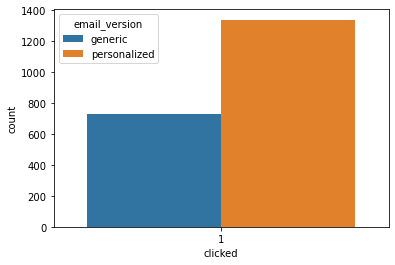

In [316]:
sns.countplot(data = df[df.clicked == 1], x='clicked',hue='email_version')

**Inference**
- we can see that personalized (hi John...) is much more effective. 
- This makes sense because people tend to open the emails/read the emails that have the personalized headings. 

#### 2.2.3 Hour/Weekday

<AxesSubplot:xlabel='hour', ylabel='clicked'>

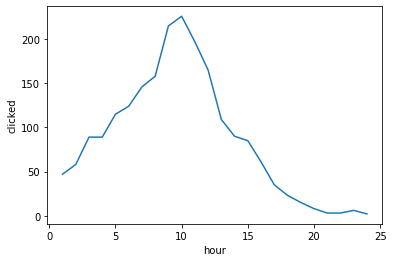

In [317]:
hour_sort = df.groupby('hour').sum('clicked').sort_values('clicked',ascending = False)
sns.lineplot(data=hour_sort, x='hour', y='clicked');

**Inference**
- We can observe that around 10 a.m., people are more inclined to click on the link.
- After 10 a.m., the click-through rate decreases.
- To increase the click-through rate, the company can aim to send out the majority of its emails around 10 a.m.

<AxesSubplot:xlabel='weekday', ylabel='clicked'>

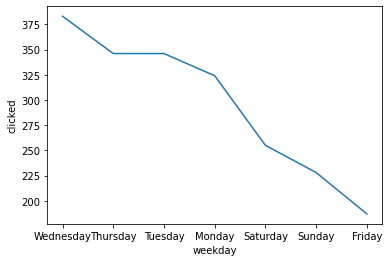

In [319]:
hour_sort = df.groupby('weekday').sum('clicked').sort_values('clicked',ascending = False)
sns.lineplot(data=hour_sort, x='weekday', y='clicked');

**Inference**
- Company should try to launch the marketing campaign on Wednesday/Thursday/Tuesday ( around Wednesday ) 
- And we should avoid Friday because people almost never click the link in the emails on Friday 

#### 2.2.4 user countries

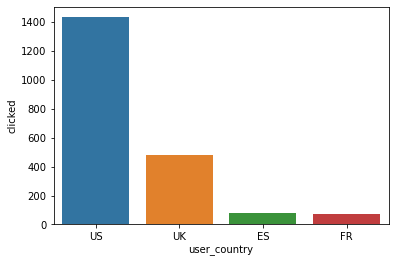

In [289]:
user_sort = df.groupby('user_country').sum('clicked').sort_values(
    'clicked', ascending=False)

user_sort = user_sort.reset_index()#reset index

sns.barplot(data=user_sort, x='user_country', y='clicked');

**Inference**
- US has the highest clicked number
- FR&ES has the lowest (for the marketing department, we should either find a way to increase the CR or abandon them)

## 3. Model Building  <a class="anchor" id="third-bullet"></a>

In [290]:
import statsmodels.api as sm

#### 3.1 Converting time into categories 

In [291]:
df.hour.value_counts().sort_values(ascending= False)

# 0 am  - 6 am : night
# 6 am - 12 pm : morning
# 12 pm - 18 pm : afternoon
# 18 pm - 24 pm : evening

df['time_category'] = ''

df.loc[df['hour'].between(0,6), 'time_category'] = 'night'
df.loc[df['hour'].between(6,12), 'time_category'] = 'morning'
df.loc[df['hour'].between(12,18), 'time_category'] = 'afternoon'
df.loc[df['hour'].between(18,24), 'time_category'] = 'evening'

df.drop('hour', axis = 1, inplace=True)

#### 3.2 Getting the reference level before converting into dummies

***Before converting the categorical variables into dummies, we need to know which ones are the reference levels for them***

In [292]:
df_category = df.select_dtypes(['object']).astype('category')

In [293]:
df_category

,email_text,email_version,weekday,user_country,time_category
email_id,,,,,
8,short_email,generic,Thursday,US,morning
33,long_email,personalized,Monday,US,morning
46,short_email,generic,Tuesday,US,afternoon
49,long_email,personalized,Thursday,US,morning
65,short_email,generic,Wednesday,UK,morning
...,...,...,...,...,...
999969,short_email,generic,Thursday,US,evening
999972,long_email,personalized,Tuesday,US,morning
999976,long_email,personalized,Wednesday,UK,night


In [294]:
print('These are the reference levels') 
print('----------------------------') 
df_category.apply(lambda x: x.cat.categories[0])

These are the reference levels
----------------------------


email_text       long_email
email_version       generic
weekday              Friday
user_country             ES
time_category     afternoon
dtype: object

#### 3.3 Dummies etc.,

In [295]:
df = pd.get_dummies(df, drop_first=True)

In [296]:
#add intercept for multiple logistc regression
df['intercept'] = 1

#Getting data and target variable
X = df.drop('clicked',axis = 1) #data
y = df['clicked'] #data

#### 3.4 Build the logistic regression model

***The reason we choose logistic model because the output is binary(clicked(yes) OR didn't click (no))***

In [297]:
#first model

logit_1 = sm.Logit(y,X).fit()

Optimization terminated successfully.
         Current function value: 0.092690
         Iterations 9


In [298]:
print(logit_1.summary())

                           Logit Regression Results                           
Dep. Variable:                clicked   No. Observations:                99950
Model:                          Logit   Df Residuals:                    99934
Method:                           MLE   Df Model:                           15
Date:                Wed, 07 Sep 2022   Pseudo R-squ.:                 0.08002
Time:                        06:17:24   Log-Likelihood:                -9264.4
converged:                       True   LL-Null:                       -10070.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
user_past_purchases            0.1879      0.006     32.809      0.000       0.177       0.199
email_text_short_email         0.2776      0.045      6.127      0.000       0.189 

**Inference**
- Weekday Sunday is not significant (p value greater than 0.05), which is consistent with what we discovered in the EDA section.
- User_country_FR is not significant (p value greater than 0.05), which is consistent with what we discovered in the EDA section.
- Time morning(6-12) has a very high P value. We should drop this variable


In [301]:
#second model

#reset X (getting rid of not significant variables)
X_2 = df.drop(['clicked','weekday_Sunday','user_country_FR','time_category_morning'],axis = 1) #data

logit_2 = sm.Logit(y,X_2).fit()

Optimization terminated successfully.
         Current function value: 0.092709
         Iterations 9


In [302]:
print(logit_2.summary())

                           Logit Regression Results                           
Dep. Variable:                clicked   No. Observations:                99950
Model:                          Logit   Df Residuals:                    99937
Method:                           MLE   Df Model:                           12
Date:                Wed, 07 Sep 2022   Pseudo R-squ.:                 0.07984
Time:                        06:20:05   Log-Likelihood:                -9266.2
converged:                       True   LL-Null:                       -10070.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
user_past_purchases            0.1880      0.006     32.808      0.000       0.177       0.199
email_text_short_email         0.2771      0.045      6.116      0.000       0.188 

**Inference**
- all variables are significant

## 4. Main takeaways  <a class="anchor" id="fourth-bullet"></a>

**4.1 user_country**
- The reference level for country is ES(Spain)
- We can see that UK/US countries perform significantly better than non-English speaking countries
    - The reason could either be that our translation is bad OR they are not our target market

***We should either hire a better team to translate the materials OR try to target different market***

**4.2 weekday**

- The reference level for weekday is Friday
- We can see that Monday to Saturday perform consistently well than Friday except Sunday which we've already removed

***We should avoid sending emails from Friday to Sunday and try to send the emails in the middle of the week as Wednesday has the highest coefficient which indicates that they can generate more clicks(the response of this model).***

**4.3 email_length**

- The reference level is long email
- shorter emails can create more clicks than the long emails

***This might indicate that we should try to make our email content concise and avoid any verbose sentences or long content***

**4.4 personalized**

- The reference level is generic email
- Personalized email generates much more clicks than the generic emails. 

***Therefore, consider how much more clicks that can be generated with personalized emails, we should try to make the emails more personalized and avoid any generic content in the following email campaign***

**4.5 time_category**

- The reference level is afternoon (12 - 18)
- We can see that evening(18-24) night(0-6) perform poorly compared to the afternoon time categories
- Morning drop because it's not significant 

***Therefore, the marketing team should aim to send out emails in the afternoon(12 am to 6 pm)***